# Characterizing the Ly$\alpha$ Forest with $f(N)$


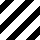
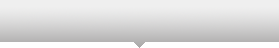
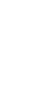
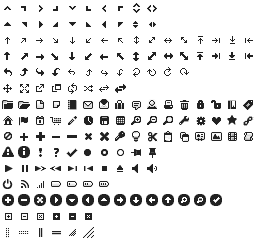
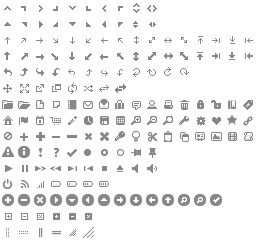
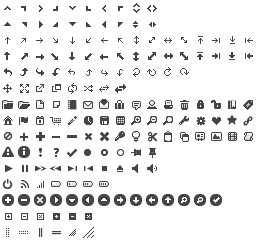
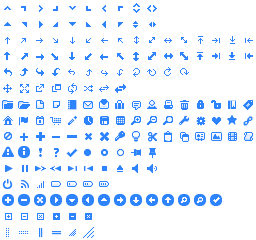
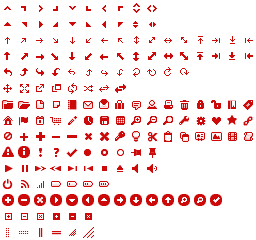
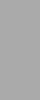
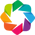
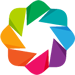
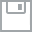
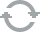
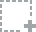
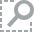
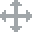
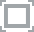
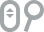

In [2]:
from pyigm.fN import mockforest as pyimock
from pyigm.fN.fnmodel import FNModel
from pyigm.fN import tau_eff as pyiteff

from linetools.guis import xspecgui

from bokeh.io import output_notebook, show, hplot, output_file
from bokeh.plotting import figure
from bokeh.models import Range1d

output_notebook()

In [3]:
# For presentation
pwdth = 600  
phght = 400
# For laptop
#pwdth = 800
#phght = 600

In [4]:
def plot_hist(*args,**kwargs):
    """
    Quick histogram plot

    Parameters
    ----------
    binsz : float 
      Width of the bin
    ax : Matplot pyplot
      Useful for sub plots
    noshow : boolean (False) 
      Set keyword to True to not show to screen
    noclear : boolean (False) 
      Set keyword to True to not clear the figure
    xmnx : tuple, optional
      (xmin, xmax) for plotting
    """
    # Error checking
    if len(args) == 0:
        print 'x_guis.simple_splot: No arguments!'
        return
    
    if not isinstance(args[0],np.ndarray):
        print 'x_guis: Input array is not a numpy.ndarray!'
        return

    plt_dict = {}

    # Bin size
    if not 'alpha' in kwargs:
        kwargs['alpha'] = 1.

    # Bin size
    if not 'binsz' in kwargs:
        if 'xrng' in kwargs:
            tmp = args[0].flatten()
            idx = np.where((tmp > kwargs['xrng'][0]) & (tmp < kwargs['xrng'][1]))[0]
            kwargs['binsz'] = float(np.std(tmp[idx])/5.)
        else:
            kwargs['binsz'] = float(np.std(args[0].flatten())/5.)
    #pdb.set_trace()

    # Clear
    if (not 'noclear' in kwargs) and (not 'ax' in kwargs):
        plt.clf()

    # Ax
    if not 'ax' in kwargs:
        ax = plt
    else:
        ax = kwargs['ax']
    
    # Plot 
    #pdb.set_trace()
    if len(args) == 1:
        arr = args[0].flatten()

        # Find the range
        if 'xrng' not in kwargs:
            minv = np.amin(arr)
            maxv = np.amax(arr)
        else:
            minv = kwargs['xrng'][0]
            maxv = kwargs['xrng'][1]
        # Set the boundaries sensibly given binsz
        i0 = int( minv / kwargs['binsz']) - 1
        i1 = int( maxv / kwargs['binsz']) + 1
        rng = tuple( kwargs['binsz']*np.array([i0,i1]) )
        nbin = i1-i0
        # Histogram
        hist, edges = np.histogram(arr, range=rng, bins=nbin)
        ax.bar(edges[:-1], hist, width=kwargs['binsz'], alpha=kwargs['alpha'])
        # Labels
        if 'xlabel' in kwargs:
            try:
                ax.set_xlabel(kwargs['xlabel'])
            except: 
                ax.xlabel(kwargs['xlabel'])
        if 'xmnx' in kwargs:
            ax.set_xlim(kwargs['xmnx'])
    else: 
        pdb.set_trace() # Not ready for this yet
        for kk in range(1,len(args)):
            fig.plot(args[0].flatten(),args[kk].flatten())

    # Finish
    if (not 'noshow' in kwargs) and (not 'ax' in kwargs):
        plt.show()

----

## Expore Q1422

In [5]:
xspecgui.main('Data/Q1422+2309.fits')

## Line density

In [6]:
# Consider 5A of spectrum at 4600A (corresponding to z = 2.8)
z = 2.8
wave = 4600.
dwave = 5.

In [7]:
# Convert to dz
dz = (1+z) * (dwave/wave)
dz

0.004130434782608695

In [8]:
# Using Kim+13 parameterization of f(N,z) -- 10^()
lz = 10**(9.4) * 10**(12.75 * (-0.52))
nlines = lz * dz
nlines

2.432180315599174

## Mock Spectra

In [9]:
# Quasar
zem = 2.5

In [10]:
# Spectral properties
s2n = 10.
sampling = 2.
R = 2000.

In [11]:
# Resultant wavelength array (using constant dwv instead of constant dv)
disp = 4000/R/sampling # Angstrom
wave = np.arange(3800., 1300*(1+zem), disp)*u.AA

In [12]:
# fN  (Prochaska+14)
fN_model = FNModel.default_model()

Using P14 spline values to generate a default model
Loading: /Users/xavier/local/Python/pyigm/pyigm/data/fN/fN_spline_z24.fits.gz


### Main call

In [13]:
# Generate (be patient)
reload(pyimock)
mock_spec, HI_comps, misc = pyimock.mk_mock(wave, zem, fN_model, s2n=s2n, fwhm=sampling)

Using a Flat LCDM cosmology: h=0.7, Om=0.3


/Users/xavier/local/Python/linetools/linetools/spectra/xspectrum1d.py:92: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


In [14]:
# Unpack misc
sub_mock, tot_tau, mock = misc

### HI lines

In [15]:
hist, edges = np.histogram(HI_comps['lgNHI'], density=True, bins=20)
# Lya
pHI = figure(plot_width=pwdth, plot_height=phght, title="NHI Histogram")
pHI.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='blue')

# Axes
pHI.xaxis.axis_label = "log NHI"
#pLee.set(y_range=Range1d(-10,2))
show(pHI)

In [16]:
hist, edges = np.histogram(HI_comps['bval'], density=True, bins=20)
# Lya
pb = figure(plot_width=pwdth, plot_height=phght, title="b Histogram")
pb.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='green')

# Axes
pb.xaxis.axis_label = "b (km/s)"
#pLee.set(y_range=Range1d(-10,2))
show(pb)

### $\tau$ spectrum

In [18]:
# Bokeh plot
# Lya
ptau = figure(plot_width=500, plot_height=400, title="Optical Depth")
# Models
ptau.line(sub_mock.wavelength.value, tot_tau, color='blue', line_width=2)#, legend='phi_D(v)')

# Axes
ptau.xaxis.axis_label = "Wavelength (Ang)"
ptau.yaxis.axis_label = "Optical Depth"
#pLee.set(y_range=Range1d(-10,2))
show(ptau)

### 'Perfect' Spectrum

In [19]:
# Bokeh plot
# Lya
phigh = figure(plot_width=600, plot_height=400, title="Perfect Spectrum")
# Models
phigh.line(sub_mock.wavelength.value, sub_mock.flux.value, color='blue', line_width=2)

# Axes
phigh.xaxis.axis_label = "Wavelength (Ang)"
phigh.yaxis.axis_label = "Normalized Flux"
#pLee.set(y_range=Range1d(-10,2))
show(phigh)

### Spectral characteristics

In [20]:
# Smooth to instrument resolution (FWHM)
dwv_sub = np.median(sub_mock.wavelength-np.roll(sub_mock.wavelength,1))
dwv = np.median(wave-np.roll(wave,1))
fwhm_sub = sampling * dwv / dwv_sub
#
smooth_mock = sub_mock.gauss_smooth(fwhm=fwhm_sub)

In [21]:
# Rebin
mock = smooth_mock.rebin(wave)

In [22]:
# Bokeh plot
# Lya
pmock = figure(plot_width=pwdth, plot_height=phght, title="Smoothed + Rebinned Spectrum")
# Models
pmock.line(mock.wavelength.value, mock.flux.value, color='blue', line_width=2)

# Axes
pmock.xaxis.axis_label = "Wavelength (Ang)"
pmock.yaxis.axis_label = "Normalized Flux"
#pLee.set(y_range=Range1d(-10,2))
show(pmock)

In [23]:
# Noise
mock.sig = np.ones(len(mock.flux))/s2n
noisy_mock = mock.add_noise()

In [24]:
# Bokeh plot
# Lya
pnmock = figure(plot_width=pwdth, plot_height=phght, title="Noisy Spectrum")
# Models
pnmock.line(noisy_mock.wavelength.value, noisy_mock.flux.value, color='blue', line_width=2)

# Axes
pnmock.xaxis.axis_label = "Wavelength (Ang)"
pnmock.yaxis.axis_label = "Normalized Flux"
#pLee.set(y_range=Range1d(-10,2))
show(pnmock)

### Final product

In [25]:
# Bokeh plot
# Lya
pfinal = figure(plot_width=pwdth, plot_height=phght, title="Final Spectrum")
# Models
pfinal.line(mock_spec.wavelength.value, mock_spec.flux.value, color='blue', line_width=2)

# Axes
pfinal.xaxis.axis_label = "Wavelength (Ang)"
pfinal.yaxis.axis_label = "Flux"
#pLee.set(y_range=Range1d(-10,2))
show(pfinal)

## Mock spectrum (HIRES)

In [26]:
# Spectral properties
s2n = 30.
sampling = 3.
R = 30000.

In [27]:
# Resultant wavelength array (using constant dwv instead of constant dv)
disp = 4000/R/sampling # Angstrom
wave = np.arange(3800., 1300*(1+zem), disp)*u.AA

In [28]:
# Generate (be patient)
reload(pyimock)
mock_echelle, HI_comps, _ = pyimock.mk_mock(wave, zem, fN_model, s2n=s2n, fwhm=sampling)

Using a Flat LCDM cosmology: h=0.7, Om=0.3


In [29]:
### Final echelle
# Bokeh plot
# Lya
pfinal = figure(plot_width=pwdth, plot_height=phght, title="Final Echelle")
# Models
pfinal.line(mock_echelle.wavelength.value, mock_echelle.flux.value, color='blue', line_width=2)

# Axes
pfinal.xaxis.axis_label = "Wavelength (Ang)"
pfinal.yaxis.axis_label = "Flux"
#pLee.set(y_range=Range1d(-10,2))
show(pfinal)

## $\tau_{\rm eff, \alpha}$

### Power-law $f(N)$

In [35]:
from pyigm.fN import fnmodel as pyifnm

In [36]:
# Initialize f(N,X)
reload(pyifnm)
kim13 = dict(B=8.59, beta=-1.52)
powerfN = pyifnm.FNModel('PowerLaw', zmnx=(2.4,3.2), param=kim13)
powerfN.evaluate((15., 2.5), None)  # f(N,X)

-14.19111630903797

#### Calculate at $z=2.5$

In [37]:
iwave = 1215.67 * (1+2.5)
zem = 2.6 # Needs to be higher than our redshift of interest
cumul = []
teff_alpha = pyiteff.lyman_ew(iwave, zem, powerfN, NHI_MIN=12.0, NHI_MAX=18, cumul=cumul)
print(teff_alpha)

0.288655279449


In [38]:
# Cumulative plot
# Bokeh plot
pcumul = figure(plot_width=pwdth, plot_height=phght, title="Cumulative teff")
# Cumul
pcumul.line(cumul[0], cumul[1], color='blue', line_width=2)

# Axes
pcumul.xaxis.axis_label = "log NHI"
pcumul.yaxis.axis_label = "Cumulative teff"
#pLee.set(y_range=Range1d(-10,2))
show(pcumul)

In [39]:
# Differential
dteff = cumul[1] - np.roll(cumul[1],1)
dteff[0] = dteff[1] # Fix first value

In [40]:
# Cumulative plot
# Bokeh plot
pdiff = figure(plot_width=pwdth, plot_height=phght, title="dteff/dlogN")
# Cumul
pdiff.line(cumul[0], dteff, color='green', line_width=2)

# Axes
pdiff.xaxis.axis_label = "log NHI"
pdiff.yaxis.axis_label = "dteff/dlogN"
#pLee.set(y_range=Range1d(-10,2))
show(pdiff)

## $\tau_{\rm eff}$ for the full Lyman Series

### Define $f(N)$

In [41]:
fN_model = FNModel.default_model() # Prochaska+14
fN_model.zmnx = (2.,4.1) # extrapolate a bit

Using P14 spline values to generate a default model
Loading: /Users/xavier/local/Python/pyigm/pyigm/data/fN/fN_spline_z24.fits.gz


### Consider a source at $z=4$

In [42]:
zem = 4
wave = np.arange(4500., 6200., 10)

In [43]:
# Calculate
all_tau = np.zeros_like(wave)
for qq,iwave in enumerate(wave):
    all_tau[qq] = pyiteff.lyman_ew(iwave, zem, fN_model)

In [44]:
# Cumulative plot
# Bokeh plot
ptteff = figure(plot_width=pwdth, plot_height=phght, title="IGM Opacity on z=4 Source")
# Cumul
ptteff.line(wave, all_tau, color='green', line_width=2)

# Axes
ptteff.xaxis.axis_label = "Observed Wavelength"
ptteff.yaxis.axis_label = "IGM Effective Opacity"
#pLee.set(y_range=Range1d(-10,2))
show(ptteff)

In [45]:
# Flux attenuation
flux = np.exp(-all_tau)

In [46]:
# Cumulative plot
# Bokeh plot
pfx = figure(plot_width=pwdth, plot_height=phght, title="IGM Transmission for a z=4 Source")
# Cumul
pfx.line(wave, flux, color='red', line_width=2)

# Axes
pfx.xaxis.axis_label = "Observed Wavelength"
pfx.yaxis.axis_label = "IGM Transmission"
pfx.set(y_range=Range1d(0,1.1))
show(pfx)

In [30]:
print(pyiteff.lyman_alpha_obs(4.89))

Calculating tau_eff from Becker+13
1.50729835071
